# **Fake News**

### **libraries - load data - splitting**

In [1]:
library(bnclassify)
library(bnlearn)
library(glmnet)
library(bnviewer)
library(magrittr)
library(tidytext)
library(stringr)
library(syuzhet)
library(dplyr)
library(quanteda)
library(Matrix.utils)
library(ggplot2)
library(SnowballC)
library(dplyr)
library(RColorBrewer)
library(stringr)
library(stopwords)
library(textstem)
library(tidyverse)
library(caret)
fig <- function(width, heigth){
 options(repr.plot.width = width, repr.plot.height = heigth)
 }
# Always load bnlearn after bnclassify, otherwise we get some objects masked when we need them


Attaching package: ‘bnlearn’


The following objects are masked from ‘package:bnclassify’:

    modelstring, narcs, nparams


Loading required package: Matrix

Loaded glmnet 4.1-4


Attaching package: ‘dplyr’


The following object is masked from ‘package:bnclassify’:

    vars


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Package version: 3.2.3
Unicode version: 14.0
ICU version: 71.1

Parallel computing: 8 of 8 threads used.

See https://quanteda.io for tutorials and examples.


Attaching package: ‘ggplot2’


The following object is masked from ‘package:bnclassify’:

    vars


Loading required package: koRpus.lang.en

Loading required package: koRpus

Loading required package: sylly

For information on available language packages for 'koRpus', run

  available.koRpus.lang()

and see ?install.koRpus.lang()



Attaching package: ‘koRpus’


The following object

In [2]:
labelled_set <- read.csv('./fake_news_db/train.csv')

if(FALSE){unlabelled_set <- read.csv('./fake_news_db/test.csv')
    print(summary(unlabelled_set))
    anyNA(unlabelled_set)}

anyNA(labelled_set)

head(labelled_set)

[1] FALSE

,Labels,Text,Text_Tag
,<int>,<chr>,<chr>
1,1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
4,1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
5,2,The economic turnaround started at the end of my term.,"economy,jobs"
6,5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education


## Attribute description
The labels used for classifying the text are:

| Labels         | Values |
|----------------|:-----:|
| True           | 5     |
| Mostly True    | 3     |
| Half True      | 2     |
| Barely True    | 0     |
| False          | 1     |
| Not Known      | 4     |

<br>
The numerical values assigned to the labels are not sorted according to truthfulness in the training set. In our classification, we keep the same labels.


	Training set:


     Labels          Text             Text_Tag        
 Min.   :0.000   Length:8192        Length:8192       
 1st Qu.:1.000   Class :character   Class :character  
 Median :2.000   Mode  :character   Mode  :character  
 Mean   :2.333                                        
 3rd Qu.:3.000                                        
 Max.   :5.000                                        


	Test set:


     Labels          Text             Text_Tag        
 Min.   :0.000   Length:2048        Length:2048       
 1st Qu.:1.000   Class :character   Class :character  
 Median :2.000   Mode  :character   Mode  :character  
 Mean   :2.309                                        
 3rd Qu.:3.000                                        
 Max.   :5.000                                        

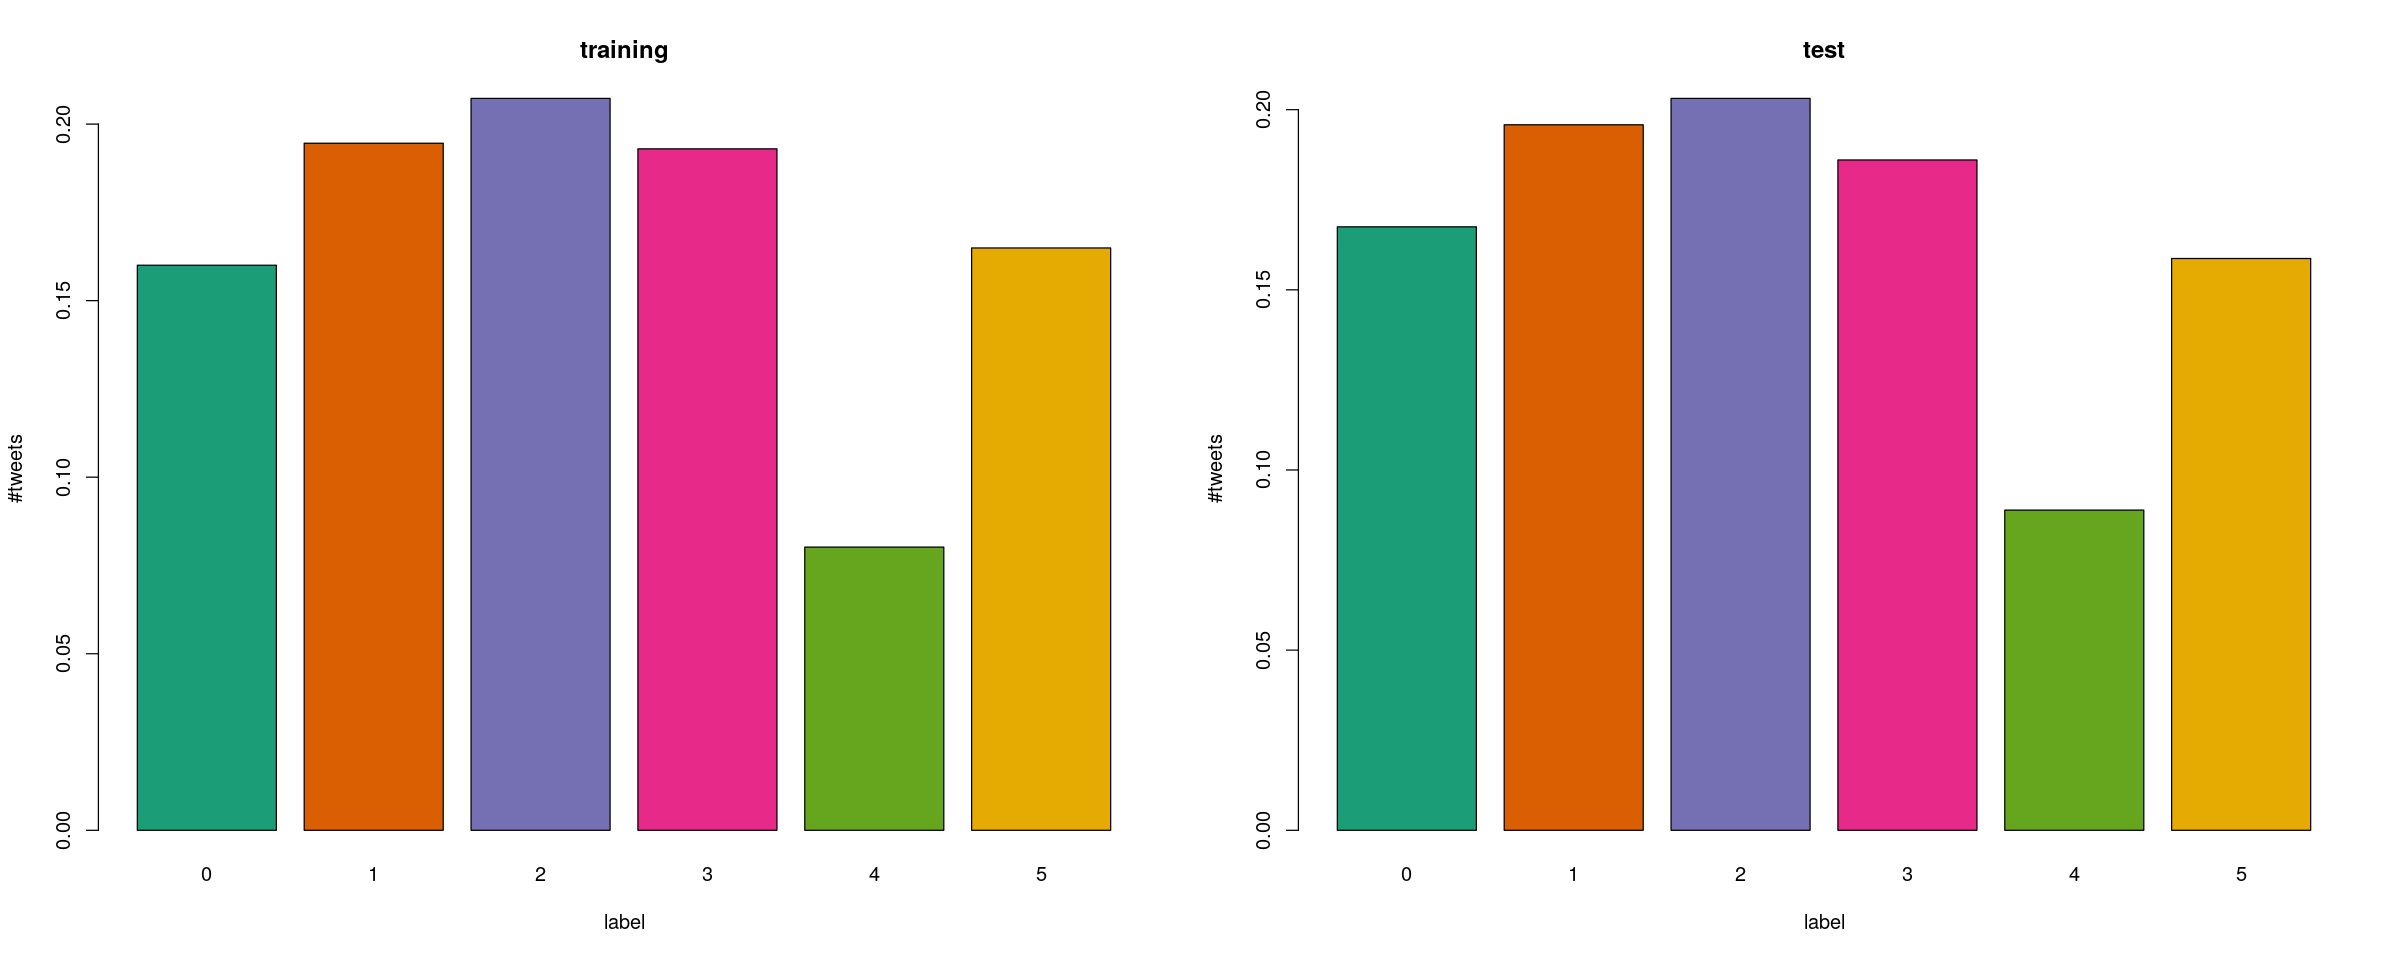

In [3]:
N <- length(labelled_set[,1])
train_fraction <- 0.8
limit <- N*train_fraction
train_set_raw <- labelled_set[1:limit,]
test_set_raw <- labelled_set[(1+limit):N,]
cat("\tTraining set:\n")
summary(train_set_raw)
cat("\n\tTest set:\n")
summary(test_set_raw)


fig(20, 8)
par(mfrow = c(1, 2))

dataset <- list(training = train_set_raw, test = test_set_raw)
for (i in 1:2) {
    label_freq <- summarise(group_by(dataset[[i]], Labels), counts = length(Labels))
    barplot(label_freq[[2]]/sum(label_freq[[2]]), names.arg = label_freq[[1]], col = brewer.pal(max(c(8, 2)), 'Dark2'), main = names(dataset)[i], xlab = 'label', ylab = '#tweets')
}

The documents are almost equally distributed among the classes. Documents labeled with '4' are an exception, as they are less than half of those in any other class. It still makes sense to use the accuracy as a measure of effectiveness of the classifier. 

## Preprocessing

In [4]:
N <- length(train_set_raw[,1]) %>% print()

[1] 8192


## Stemming

In [5]:
train_set <- unnest_tokens(
  tbl = train_set_raw,
  output = "words",
  input = "Text",
  token = "words",
  format = c("text", "man", "latex", "html", "xml"),
  to_lower = TRUE,
  drop = FALSE,
  collapse = NULL
)
train_set <- mutate(train_set, word_stem = wordStem(words, language="english"))
train_set <- train_set %>% group_by(Text)  %>%
                    dplyr::summarise(doc_id = paste(word_stem, collapse = " "))
train_set <- merge(train_set_raw, train_set, by='Text')


test_set <- unnest_tokens(
  tbl = test_set_raw,
  output = "words",
  input = "Text",
  token = "words",
  format = c("text", "man", "latex", "html", "xml"),
  to_lower = TRUE,
  drop = FALSE,
  collapse = NULL
)
test_set <- mutate(test_set, word_stem = wordStem(words, language="english"))
test_set <- test_set %>% group_by(Text)  %>%
                    dplyr::summarise(doc_id = paste(word_stem, collapse = " "))
test_set <- merge(test_set_raw, test_set, by='Text')

head(train_set)

,Text,Labels,Text_Tag,doc_id
,<chr>,<int>,<chr>,<chr>
1,... study after study has shown that the death penalty deters murders.,2,crime,studi after studi has shown that the death penalti deter murder
2,"...Over 30 years, federal spending on education has grown by 375 percent, but test scores remain flat.",3,"education,federal-budget",over 30 year feder spend on educ has grown by 375 percent but test score remain flat
3,"...some of those (tax increases) were either court-ordered, or they were voted on by the people and approved by the people for (such) things as roads.",2,taxes,some of those tax increas were either court order or they were vote on by the peopl and approv by the peopl for such thing as road
4,''I have received more contributions than any other candidate in the race Republican or Democrat.'',1,elections,i have receiv more contribut than ani other candid in the race republican or democrat
5,(After the auto bailout) General Motors is back on top as the worlds No. 1 automaker.,2,"economy,jobs",after the auto bailout general motor is back on top as the world no 1 automak
6,"(Big banks) have invested over $300,000 in (Joe Heck), and Heck has sponsored $44 million dollars in tax breaks for banks.",0,campaign-finance,"big bank have invest over 300,000 in joe heck and heck has sponsor 44 million dollar in tax break for bank"


## Sentiment

In [6]:
emotions <- get_nrc_sentiment(train_set$Text, cl = NULL, language = "english", lowercase = TRUE)
train_set <- cbind(train_set, emotions)
train_set

Warning message:
“`spread_()` was deprecated in tidyr 1.2.0.
Please use `spread()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


Text,Labels,Text_Tag,doc_id,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
... study after study has shown that the death penalty deters murders.,2,crime,studi after studi has shown that the death penalti deter murder,2,1,1,2,0,2,1,0,2,1
"...Over 30 years, federal spending on education has grown by 375 percent, but test scores remain flat.",3,"education,federal-budget",over 30 year feder spend on educ has grown by 375 percent but test score remain flat,0,0,0,0,0,0,0,0,0,0
"...some of those (tax increases) were either court-ordered, or they were voted on by the people and approved by the people for (such) things as roads.",2,taxes,some of those tax increas were either court order or they were vote on by the peopl and approv by the peopl for such thing as road,1,1,0,1,0,1,0,0,1,0
''I have received more contributions than any other candidate in the race Republican or Democrat.'',1,elections,i have receiv more contribut than ani other candid in the race republican or democrat,0,0,0,0,0,0,0,0,0,2
(After the auto bailout) General Motors is back on top as the worlds No. 1 automaker.,2,"economy,jobs",after the auto bailout general motor is back on top as the world no 1 automak,0,1,0,0,0,0,0,2,0,2
"(Big banks) have invested over $300,000 in (Joe Heck), and Heck has sponsored $44 million dollars in tax breaks for banks.",0,campaign-finance,"big bank have invest over 300,000 in joe heck and heck has sponsor 44 million dollar in tax break for bank",0,0,0,0,0,1,0,0,1,0
"(Birmingham, Ala.) is the cradle of the civil rights movement.",0,"civil-rights,history",birmingham ala is the cradl of the civil right movement,0,1,0,0,1,0,0,1,0,2
"(Brendan) Doherty wants to raise the eligibility age for Social Security benefits for anyone born after 1960, with no regard for the challenges it would cause for people working in physically demanding occupations.",1,"federal-budget,health-care,medicare,social-security",brendan doherti want to rais the elig age for social secur benefit for anyon born after 1960 with no regard for the challeng it would caus for peopl work in physic demand occup,0,0,0,0,0,0,0,0,1,1
"(Chris Christie) has not paid one dollar of state money into our pension system, and then states that the system is broke.",3,"retirement,state-budget",chris christi has not paid one dollar of state money into our pension system and then state that the system is broke,1,1,0,1,1,1,1,2,1,1


## General parameters

In [7]:
train_set$length <- nchar(train_set$Text)
train_set$esclam_mark <- str_count(train_set$Text, "!")
train_set$commas <- str_count(train_set$Text, ",")
train_set$two_points <- str_count(train_set$Text, ":")
train_set$semicolon <- str_count(train_set$Text, ";")

train_set

Text,Labels,Text_Tag,doc_id,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,length,esclam_mark,commas,two_points,semicolon
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
... study after study has shown that the death penalty deters murders.,2,crime,studi after studi has shown that the death penalti deter murder,2,1,1,2,0,2,1,0,2,1,70,0,0,0,0
"...Over 30 years, federal spending on education has grown by 375 percent, but test scores remain flat.",3,"education,federal-budget",over 30 year feder spend on educ has grown by 375 percent but test score remain flat,0,0,0,0,0,0,0,0,0,0,102,0,2,0,0
"...some of those (tax increases) were either court-ordered, or they were voted on by the people and approved by the people for (such) things as roads.",2,taxes,some of those tax increas were either court order or they were vote on by the peopl and approv by the peopl for such thing as road,1,1,0,1,0,1,0,0,1,0,150,0,1,0,0
''I have received more contributions than any other candidate in the race Republican or Democrat.'',1,elections,i have receiv more contribut than ani other candid in the race republican or democrat,0,0,0,0,0,0,0,0,0,2,99,0,0,0,0
(After the auto bailout) General Motors is back on top as the worlds No. 1 automaker.,2,"economy,jobs",after the auto bailout general motor is back on top as the world no 1 automak,0,1,0,0,0,0,0,2,0,2,85,0,0,0,0
"(Big banks) have invested over $300,000 in (Joe Heck), and Heck has sponsored $44 million dollars in tax breaks for banks.",0,campaign-finance,"big bank have invest over 300,000 in joe heck and heck has sponsor 44 million dollar in tax break for bank",0,0,0,0,0,1,0,0,1,0,122,0,2,0,0
"(Birmingham, Ala.) is the cradle of the civil rights movement.",0,"civil-rights,history",birmingham ala is the cradl of the civil right movement,0,1,0,0,1,0,0,1,0,2,62,0,1,0,0
"(Brendan) Doherty wants to raise the eligibility age for Social Security benefits for anyone born after 1960, with no regard for the challenges it would cause for people working in physically demanding occupations.",1,"federal-budget,health-care,medicare,social-security",brendan doherti want to rais the elig age for social secur benefit for anyon born after 1960 with no regard for the challeng it would caus for peopl work in physic demand occup,0,0,0,0,0,0,0,0,1,1,214,0,1,0,0
"(Chris Christie) has not paid one dollar of state money into our pension system, and then states that the system is broke.",3,"retirement,state-budget",chris christi has not paid one dollar of state money into our pension system and then state that the system is broke,1,1,0,1,1,1,1,2,1,1,122,0,1,0,0


In [6]:
colnames(train_set)

[1] "Text"     "Labels"   "Text_Tag" "doc_id"

## 1-grams

In [8]:
gram_sparse_create <- function(dataset, rarity, toocommon){
    tidy_tweets1 <- unnest_tokens(dataset, "term", "doc_id", token = "words", drop = FALSE)
    
    tidy_tweets1 <- tidy_tweets1 %>% dplyr::count(Labels, doc_id, term) %>% filter(!(term %in% too_common))
    
    too_rare <- (tidy_tweets1 %>% dplyr::count(term) %>% filter(!(term %in% too_common)) %>% filter(n < rarity))$term

    tidy_tweets1 <- tidy_tweets1 %>% dplyr::count(Labels, doc_id, term) %>% filter(!(term %in% too_common)) %>% filter(!(term %in% too_rare))
    
    cast_tweets1 <- tidy_tweets1 %>% cast_dfm(doc_id, term, n) %>% convert(to = "data.frame")
    
    return(cast_tweets1)
}

## n>1 - grams

In [7]:
ngram_sparse_create <- function(dataset, nn, rarity){
    tidy_tweetsn <- unnest_tokens(dataset, "term", "doc_id", token = "ngrams", n = nn, drop = FALSE)
    
    tidy_tweetsn <- tidy_tweetsn %>% dplyr::count(Labels, doc_id, term) #%>% filter(!(term %in% too_common))
    too_raren <- (tidy_tweetsn %>% dplyr::count(term) %>% filter(n < rarity))$term #%>% filter(!(term %in% too_common)) 
    tidy_tweetsn <- tidy_tweetsn %>% dplyr::count(Labels, doc_id, term) %>% filter(!(term %in% too_raren)) #%>% filter(!(term %in% too_common))
    
    cast_tweetsn <- tidy_tweetsn %>% cast_dfm(doc_id, term, n) %>% convert(to = "data.frame") 
    
    return(cast_tweetsn)
}

In [9]:
too_common <- c("in", "the", "of", "to", "a", "and", "they", "or", "for", "that", "says", "we", 
             "more", "at", "be", "about", "will", "one", "an", "his", "you", "their", "is", 
             "on", "has", "have", "are", "was", "by", "it", "from", "with", "as", "not", "our", 
             "I", "this", "he", "been")

make_extended_dfm <- function(dframe, highest_gram, minimum_frequencies){
    
    dfm <- merge(x = dframe, 
                y = gram_sparse_create(dframe, minimum_frequencies[1], toocommon),
                by = "doc_id", 
                all = TRUE)
    
    for (i in 2:highest_gram) {
        dfm <- merge(x = dfm, 
                     y = ngram_sparse_create(dframe, i, minimum_frequencies[i]),
                     by = "doc_id", 
                     all = TRUE)
    }
    
    return(dfm)
 }

In [10]:
dfm <- make_extended_dfm(train_set, 4, c(50, 50, 50, 20)) 
dfm[is.na(dfm)] <- 0
head(dfm)

,doc_id,Text,Labels,Text_Tag,1,3,colleg,go,high,kid,⋯,for the first time,the first time in,in the histori of,in the unit state,of the unit state,percent of the time,the health care law,say presid barack obama,the unit state has,in the state of
,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1 3 of our kid drop out of high school cannot go to colleg or start a career,"1/3 of our kids drop out (of high school), cannot go to college or start a career.",0,"corrections-and-updates,education",1,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
2,1 percent of candid that the nation rifl associ endors in 2012 won,1 percent of candidates that (the National Rifle Association) endorsed in 2012 won.,1,"campaign-finance,guns,pundits",1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,1.53 million job are at risk from potenti defens cut,1.53 million jobs are at risk (from potential defense cuts).,3,"deficit,jobs,message-machine-2012,military",0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,10 cent on thedollar from the clinton foundat goe to charit caus,10 cents on thedollar from the Clinton Foundation goes to charitable causes.,1,candidates-biography,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,100 percent of the crime is commit in estim by about 15 percent of the popul,"100 percent of the crime is committed, in estimate, by about 15 percent of the population.",4,"corrections-and-updates,crime,criminal-justice,population",0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,"100,000 in stimulus fund were use for a martini bar and brazilian steakhous","$100,000 in stimulus funds (were) used for a Martini Bar and Brazilian Steakhouse.",3,stimulus,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Classifier

In [12]:
df_count <- aggregate(.~Labels, 
                      data = dfm[, -which(names(dfm) == "Text" | names(dfm) == "Text_Tag" | names(dfm) == "doc_id")], 
                      FUN = sum)
df_count

Labels,1,3,colleg,go,high,kid,out,school,start,⋯,for the first time,the first time in,in the histori of,in the unit state,of the unit state,percent of the time,the health care law,say presid barack obama,the unit state has,in the state of
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,26,7,15,44,16,6,56,38,6,⋯,4,4,3,14,3,2,4,8,2,1
1,25,10,10,49,13,9,60,33,8,⋯,6,2,3,16,4,1,9,11,4,6
2,39,16,24,38,23,13,63,63,22,⋯,4,3,3,21,5,7,3,6,5,6
3,47,14,26,38,21,11,60,46,16,⋯,10,11,7,25,6,5,2,10,7,3
4,8,4,4,23,5,2,18,21,4,⋯,0,0,3,4,2,0,2,3,1,1
5,38,7,22,28,16,10,43,38,12,⋯,5,4,3,17,3,5,1,1,3,4


In [13]:
df_count <- df_count + 1
df_count$Labels <- df_count$Labels - 1
label.density <- dfm %>% group_by(Labels) %>% summarize(counts = n_distinct(doc_id))
label.density$counts <- label.density$counts/sum(label.density$counts)
df_count$label.density <- label.density$counts
df_count$total.num <- rowSums(df_count[, -which(names(df_count) == "Labels" | names(df_count) == "label.density" )])  #summing over the rows
df_count

Labels,1,3,colleg,go,high,kid,out,school,start,⋯,in the histori of,in the unit state,of the unit state,percent of the time,the health care law,say presid barack obama,the unit state has,in the state of,label.density,total.num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,27,8,16,45,17,7,57,39,7,⋯,4,15,4,3,5,9,3,2,0.16022977,12794
1,26,11,11,50,14,10,61,34,9,⋯,4,17,5,2,10,12,5,7,0.19396236,14733
2,40,17,25,39,24,14,64,64,23,⋯,4,22,6,8,4,7,6,7,0.20728428,17224
3,48,15,27,39,22,12,61,47,17,⋯,8,26,7,6,3,11,8,4,0.19322904,16080
4,9,5,5,24,6,3,19,22,5,⋯,4,5,3,1,3,4,2,2,0.08029822,6039
5,39,8,23,29,17,11,44,39,13,⋯,4,18,4,6,2,2,4,5,0.16499633,13063


In [14]:
df_count[, -which(names(df_count) == "Labels" | names(df_count) == "label.density" | names(df_count) == "total.num")] <- df_count[, -which(names(df_count) == "Labels" | names(df_count) == "label.density" | names(df_count) == "total.num")]/df_count$total.num #loop on 5 indexes
df_count
# occhio che lui lo fa con un ciclo for

Labels,1,3,colleg,go,high,kid,out,school,start,⋯,in the histori of,in the unit state,of the unit state,percent of the time,the health care law,say presid barack obama,the unit state has,in the state of,label.density,total.num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.002110364,0.0006252931,0.0012505862,0.003517274,0.0013287479,0.0005471315,0.004455213,0.003048304,0.0005471315,⋯,0.0003126466,0.0011724246,0.0003126466,0.0002344849,0.0003908082,0.0007034547,0.0002344849,0.0001563233,0.16022977,12794
1,0.001764746,0.0007466232,0.0007466232,0.003393742,0.0009502477,0.0006787484,0.004140365,0.002307745,0.0006108735,⋯,0.0002714994,0.0011538723,0.0003393742,0.0001357497,0.0006787484,0.0008144981,0.0003393742,0.0004751239,0.19396236,14733
2,0.002322341,0.0009869949,0.0014514631,0.002264282,0.0013934046,0.0008128193,0.003715745,0.003715745,0.0013353460,⋯,0.0002322341,0.0012772875,0.0003483511,0.0004644682,0.0002322341,0.0004064097,0.0003483511,0.0004064097,0.20728428,17224
3,0.002985075,0.0009328358,0.0016791045,0.002425373,0.0013681592,0.0007462687,0.003793532,0.002922886,0.0010572139,⋯,0.0004975124,0.0016169154,0.0004353234,0.0003731343,0.0001865672,0.0006840796,0.0004975124,0.0002487562,0.19322904,16080
4,0.001490313,0.0008279516,0.0008279516,0.003974168,0.0009935420,0.0004967710,0.003146216,0.003642987,0.0008279516,⋯,0.0006623613,0.0008279516,0.0004967710,0.0001655903,0.0004967710,0.0006623613,0.0003311807,0.0003311807,0.08029822,6039
5,0.002985532,0.0006124167,0.0017606982,0.002220011,0.0013013856,0.0008420730,0.003368292,0.002985532,0.0009951772,⋯,0.0003062084,0.0013779377,0.0003062084,0.0004593126,0.0001531042,0.0001531042,0.0003062084,0.0003827605,0.16499633,13063


## Predictor

In [84]:
dfm[4,-which(names(dfm) == "doc_id" | names(dfm) == "Text" | names(dfm) == "Text_Tag")]
df_count[,-which(names(df_count) == "total.num" | names(df_count) == "label.density")]

,Labels,1,3,colleg,go,high,kid,out,school,start,⋯,for the first time,the first time in,in the histori of,in the unit state,of the unit state,percent of the time,the health care law,say presid barack obama,the unit state has,in the state of
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Labels,1,3,colleg,go,high,kid,out,school,start,⋯,for the first time,the first time in,in the histori of,in the unit state,of the unit state,percent of the time,the health care law,say presid barack obama,the unit state has,in the state of
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.002110364,0.0006252931,0.0012505862,0.003517274,0.0013287479,0.0005471315,0.004455213,0.003048304,0.0005471315,⋯,0.0003908082,0.0003908082,0.0003126466,0.0011724246,0.0003126466,0.0002344849,0.0003908082,0.0007034547,0.0002344849,0.0001563233
1,0.001764746,0.0007466232,0.0007466232,0.003393742,0.0009502477,0.0006787484,0.004140365,0.002307745,0.0006108735,⋯,0.0004751239,0.0002036245,0.0002714994,0.0011538723,0.0003393742,0.0001357497,0.0006787484,0.0008144981,0.0003393742,0.0004751239
2,0.002322341,0.0009869949,0.0014514631,0.002264282,0.0013934046,0.0008128193,0.003715745,0.003715745,0.0013353460,⋯,0.0002902926,0.0002322341,0.0002322341,0.0012772875,0.0003483511,0.0004644682,0.0002322341,0.0004064097,0.0003483511,0.0004064097
3,0.002985075,0.0009328358,0.0016791045,0.002425373,0.0013681592,0.0007462687,0.003793532,0.002922886,0.0010572139,⋯,0.0006840796,0.0007462687,0.0004975124,0.0016169154,0.0004353234,0.0003731343,0.0001865672,0.0006840796,0.0004975124,0.0002487562
4,0.001490313,0.0008279516,0.0008279516,0.003974168,0.0009935420,0.0004967710,0.003146216,0.003642987,0.0008279516,⋯,0.0001655903,0.0001655903,0.0006623613,0.0008279516,0.0004967710,0.0001655903,0.0004967710,0.0006623613,0.0003311807,0.0003311807
5,0.002985532,0.0006124167,0.0017606982,0.002220011,0.0013013856,0.0008420730,0.003368292,0.002985532,0.0009951772,⋯,0.0004593126,0.0003827605,0.0003062084,0.0013779377,0.0003062084,0.0004593126,0.0001531042,0.0001531042,0.0003062084,0.0003827605


In [90]:
x<-dfm[10,-which(names(dfm) == "doc_id" | names(dfm) == "Text" | names(dfm) == "Text_Tag")]
a <- x[,which(x != 0)]
a
df.one      <- df_count[,-which(names(df_count) == "total.num" | names(df_count) == "label.density")]
b <- df.one[,which(x != 0)]
b

,Labels,vote,them,but,governor
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
10,1,1,1,1,1


Labels,vote,them,but,governor
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.007894325,0.001328748,0.002891981,0.001641394
1,0.006787484,0.002036245,0.001968370,0.002171995
2,0.004760799,0.001219229,0.002612634,0.002322341
3,0.006032338,0.001181592,0.002860697,0.001927861
4,0.007120384,0.002649445,0.001324723,0.001987084
5,0.005971063,0.001301386,0.002066907,0.002526219


In [91]:
a[,-1]
b[,-1]

,vote,them,but,governor
,<dbl>,<dbl>,<dbl>,<dbl>
10,1,1,1,1


vote,them,but,governor
<dbl>,<dbl>,<dbl>,<dbl>
0.007894325,0.001328748,0.002891981,0.001641394
0.006787484,0.002036245,0.001968370,0.002171995
0.004760799,0.001219229,0.002612634,0.002322341
0.006032338,0.001181592,0.002860697,0.001927861
0.007120384,0.002649445,0.001324723,0.001987084
0.005971063,0.001301386,0.002066907,0.002526219


In [92]:
power.func  <- function(y){return(y <- y**as.matrix(a[,-1]))} #each prob to the power of repeatence
c      <- t(apply(as.matrix(b[,-1]) ,1, power.func))  #applyting the power function
c <- cbind(c, df_count$Label.density)
c

0.007894325,0.001328748,0.002891981,0.001641394
0.006787484,0.002036245,0.001968370,0.002171995
0.004760799,0.001219229,0.002612634,0.002322341
0.006032338,0.001181592,0.002860697,0.001927861
0.007120384,0.002649445,0.001324723,0.001987084
0.005971063,0.001301386,0.002066907,0.002526219


In [93]:
prob.finder      <- function(x){return(prod(x))}  #a function which stores the product of all probs.  
df.final         <<- cbind(c, Label.Prob = apply(c, 1, prob.finder)) #dataframe of porbs for each sample
df.final         <<- cbind(df.final, Label = 0:5) #dataframe of porbs for each sample 
df.final         <<- data.frame(df.final)
df.final

V1,V2,V3,V4,Label.Prob,Label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.007894325,0.001328748,0.002891981,0.001641394,4.979273e-11,0
0.006787484,0.002036245,0.001968370,0.002171995,5.908871e-11,1
0.004760799,0.001219229,0.002612634,0.002322341,3.521840e-11,2
0.006032338,0.001181592,0.002860697,0.001927861,3.930979e-11,3
0.007120384,0.002649445,0.001324723,0.001987084,4.965918e-11,4
0.005971063,0.001301386,0.002066907,0.002526219,4.057416e-11,5


In [94]:
predicted_label  <- df.final$Label[which(df.final$Label.Prob == max(df.final$Label.Prob))] #the final predicted label 
predicted_label

[1] 1

In [ ]:
score <- function(Y_test, Y_pred){length(Y_test[Y_test == Y_pred])/length(Y_test)}

# **WRAP TOGETHER**

# Loading the data and splitting

In [2]:
labelled_set <- read.csv('./fake_news_db/train.csv')

if(FALSE){unlabelled_set <- read.csv('./fake_news_db/test.csv')
    print(summary(unlabelled_set))
    anyNA(unlabelled_set)}

anyNA(labelled_set)

head(labelled_set)

[1] FALSE

,Labels,Text,Text_Tag
,<int>,<chr>,<chr>
1,1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
4,1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
5,2,The economic turnaround started at the end of my term.,"economy,jobs"
6,5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education


### Attribute description
The labels used for classifying the text are:

| Labels         | Values |
|----------------|:-----:|
| True           | 5     |
| Mostly True    | 3     |
| Half True      | 2     |
| Barely True    | 0     |
| False          | 1     |
| Not Known      | 4     |

<br>
The numerical values assigned to the labels are not sorted according to truthfulness in the training set. In our classification, we keep the same labels.


	Training set:


     Labels          Text             Text_Tag        
 Min.   :0.000   Length:8192        Length:8192       
 1st Qu.:1.000   Class :character   Class :character  
 Median :2.000   Mode  :character   Mode  :character  
 Mean   :2.333                                        
 3rd Qu.:3.000                                        
 Max.   :5.000                                        


	Test set:


     Labels          Text             Text_Tag        
 Min.   :0.000   Length:2048        Length:2048       
 1st Qu.:1.000   Class :character   Class :character  
 Median :2.000   Mode  :character   Mode  :character  
 Mean   :2.309                                        
 3rd Qu.:3.000                                        
 Max.   :5.000                                        

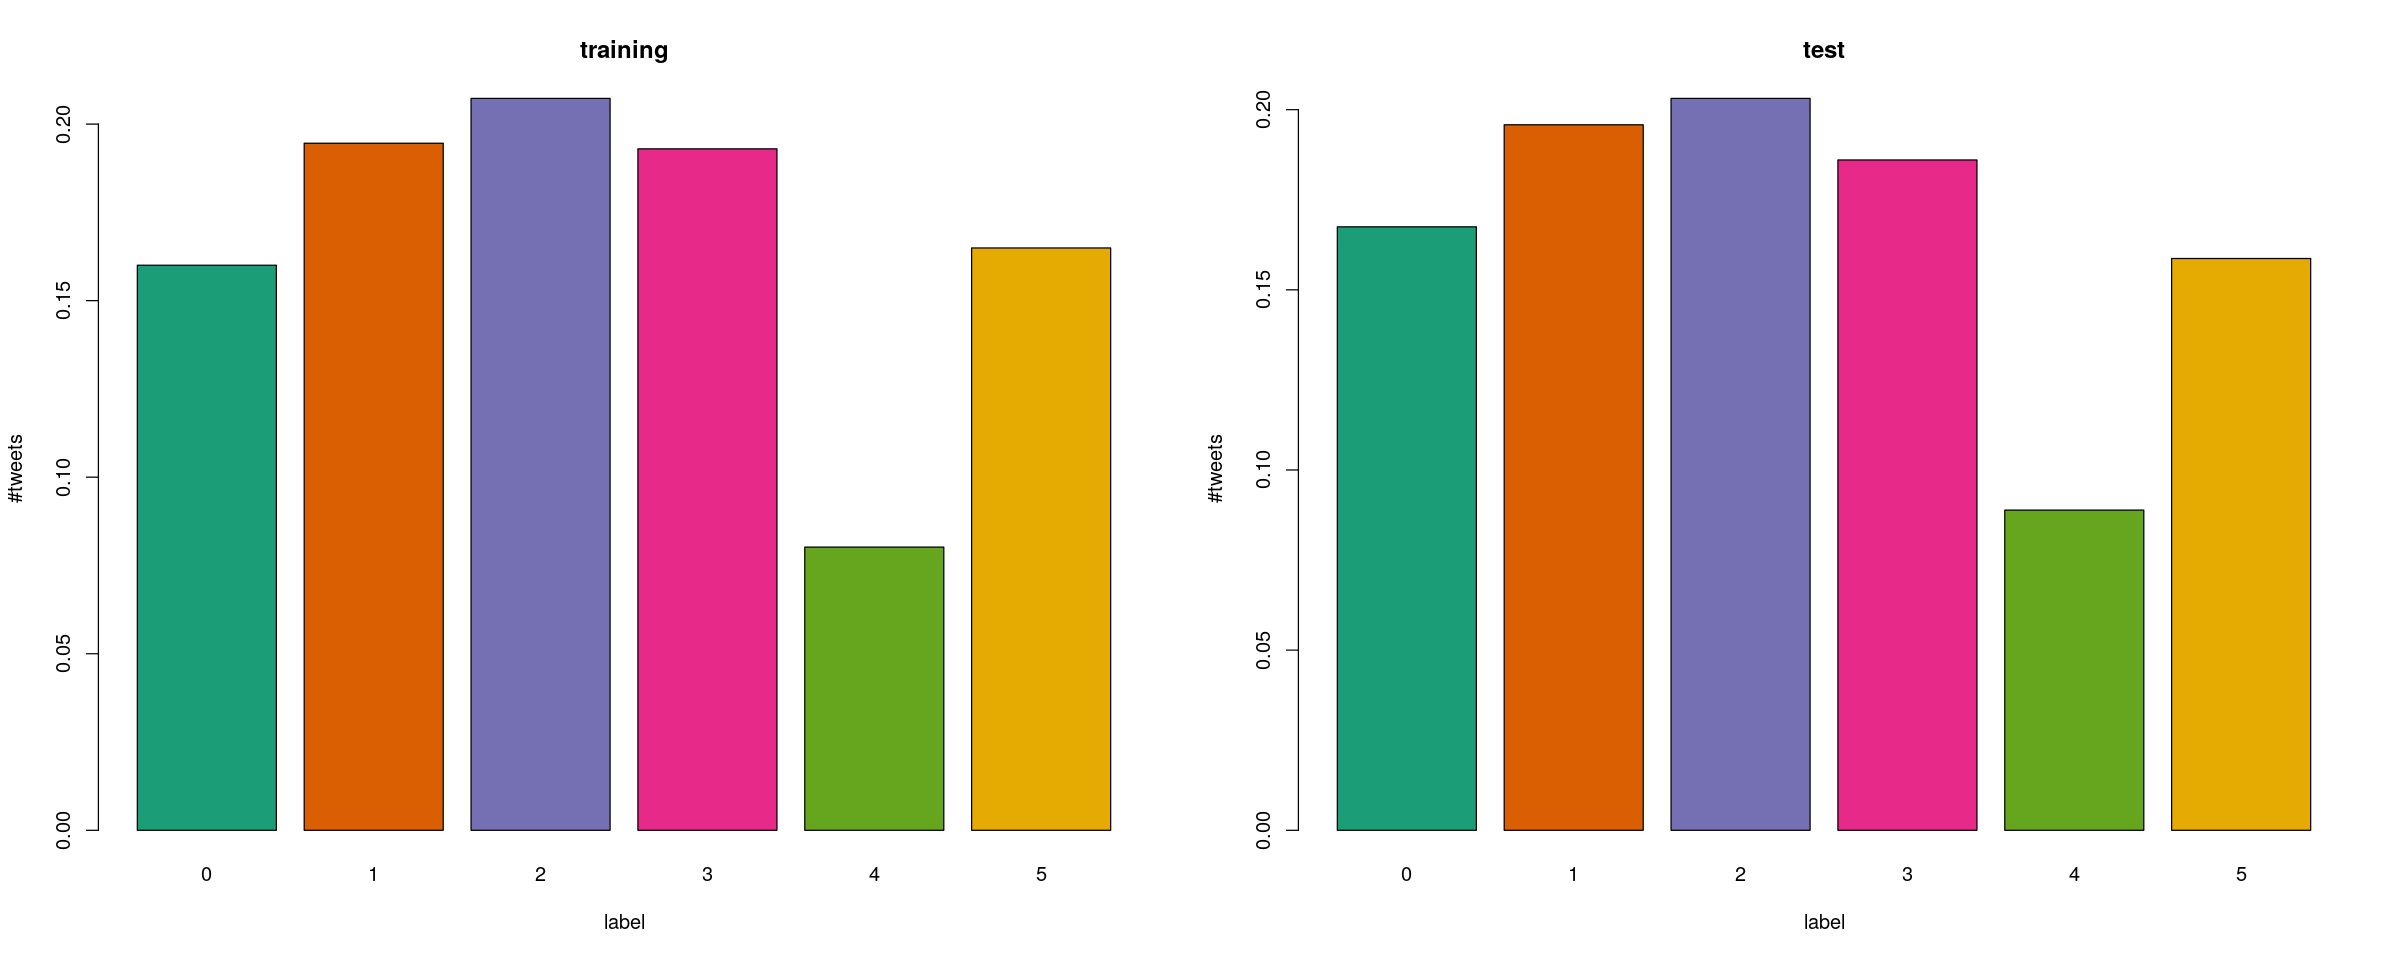

In [3]:
N <- length(labelled_set[,1])
train_fraction <- 0.8
limit <- N*train_fraction
train_set_raw <- labelled_set[1:limit,]
test_set_raw <- labelled_set[(1+limit):N,]
cat("\tTraining set:\n")
summary(train_set_raw)
cat("\n\tTest set:\n")
summary(test_set_raw)


fig(20, 8)
par(mfrow = c(1, 2))

dataset <- list(training = train_set_raw, test = test_set_raw)
for (i in 1:2) {
    label_freq <- summarise(group_by(dataset[[i]], Labels), counts = length(Labels))
    barplot(label_freq[[2]]/sum(label_freq[[2]]), names.arg = label_freq[[1]], col = brewer.pal(max(c(8, 2)), 'Dark2'), main = names(dataset)[i], xlab = 'label', ylab = '#tweets')
}

## Stemming

In [4]:
stemming <- function(raw_set){
    set <- unnest_tokens(
      tbl = raw_set,
      output = "words",
      input = "Text",
      token = "words",
      format = c("text", "man", "latex", "html", "xml"),
      to_lower = TRUE,
      drop = FALSE,
      collapse = NULL
    )
    set <- mutate(set, word_stem = wordStem(words, language="english"))
    set <- set %>% group_by(Text)  %>%
                        dplyr::summarise(doc_id = paste(word_stem, collapse = " "))
    set <- merge(raw_set, set, by='Text')
    return (set)}

In [5]:
train_set <- stemming(train_set_raw)
head(train_set)

test_set <- stemming(test_set_raw)
head(test_set)


,Text,Labels,Text_Tag,doc_id
,<chr>,<int>,<chr>,<chr>
1,... study after study has shown that the death penalty deters murders.,2,crime,studi after studi has shown that the death penalti deter murder
2,"...Over 30 years, federal spending on education has grown by 375 percent, but test scores remain flat.",3,"education,federal-budget",over 30 year feder spend on educ has grown by 375 percent but test score remain flat
3,"...some of those (tax increases) were either court-ordered, or they were voted on by the people and approved by the people for (such) things as roads.",2,taxes,some of those tax increas were either court order or they were vote on by the peopl and approv by the peopl for such thing as road
4,''I have received more contributions than any other candidate in the race Republican or Democrat.'',1,elections,i have receiv more contribut than ani other candid in the race republican or democrat
5,(After the auto bailout) General Motors is back on top as the worlds No. 1 automaker.,2,"economy,jobs",after the auto bailout general motor is back on top as the world no 1 automak
6,"(Big banks) have invested over $300,000 in (Joe Heck), and Heck has sponsored $44 million dollars in tax breaks for banks.",0,campaign-finance,"big bank have invest over 300,000 in joe heck and heck has sponsor 44 million dollar in tax break for bank"


,Text,Labels,Text_Tag,doc_id
,<chr>,<int>,<chr>,<chr>
1,"(Bill) McCollum also voted for numerous amendments to weaken the legislation, even voting to make trains less accessible to those in wheelchairs.",5,disability,bill mccollum also vote for numer amend to weaken the legisl even vote to make train less access to those in wheelchair
2,(I) helped to invent a system that saved over a billion dollars on welfare.,5,"candidates-biography,economy,families,federal-budget,government-efficiency,poverty",i help to invent a system that save over a billion dollar on welfar
3,"(Mary) Burkes company, Trek Bicycles, makes 99% of their bikes overseas.",3,"labor,workers",mari burk compani trek bicycl make 99 of their bike oversea
4,(Pete) Sessions has held at least two fundraisers at adult-themed clubs and made no apologies.,2,ethics,pete session has held at least two fundrais at adult theme club and made no apolog
5,"(President Barack Obama gave) half a billion in taxpayer money to help his friends at Solyndra, a business the White House knew was on the path to bankruptcy.",0,"campaign-finance,corporations,energy,ethics,jobs,stimulus",presid barack obama gave half a billion in taxpay money to help his friend at solyndra a busi the white hous knew was on the path to bankruptci
6,(Rep. Bob Goodlattes) balanced budgetamendment does not require a balanced budget.,0,"deficit,federal-budget",rep bob goodlatt balanc budgetamend doe not requir a balanc budget


## Feature generation

In [6]:
feature_generation <- function(set, emotion = TRUE, punctuation = TRUE, ngrams = TRUE, highest_gram, minimum_frequencies, toocommon){
    
    if(emotion){
        detected_emotions <- get_nrc_sentiment(set$Text, cl = NULL, language = "english", lowercase = TRUE)
        set <- cbind(set, detected_emotions)
    }
    
    if(punctuation){
        set$length <- nchar(set$Text)
        set$esclam_mark <- str_count(set$Text, "!")
        set$commas <- str_count(set$Text, ",")
        set$two_points <- str_count(set$Text, ":")
        set$semicolon <- str_count(set$Text, ";")        
    }
    
    if(ngrams){
        set <- make_extended_dfm(set, highest_gram, minimum_frequencies, toocommon)
    }
    
    set[is.na(set)] <- 0

    return(set)}

#-----------------------------------------------------------------------------------------------------------------------------------------

gram_sparse_create <- function(dataset, rarity, toocommon){
    tidy_tweets1 <- unnest_tokens(dataset, "term", "doc_id", token = "words", drop = FALSE)
    tidy_tweets1 <- tidy_tweets1 %>% dplyr::count(Labels, doc_id, term) %>% filter(!(term %in% too_common))
    too_rare <- (tidy_tweets1 %>% dplyr::count(term) %>% filter(!(term %in% too_common)) %>% filter(n < rarity))$term
    tidy_tweets1 <- tidy_tweets1 %>% dplyr::count(Labels, doc_id, term) %>% filter(!(term %in% too_common)) %>% filter(!(term %in% too_rare))
    cast_tweets1 <- tidy_tweets1 %>% cast_dfm(doc_id, term, n) %>% convert(to = "data.frame")
    return(cast_tweets1)
}

#-----------------------------------------------------------------------------------------------------------------------------------------

ngram_sparse_create <- function(dataset, nn, rarity){
    tidy_tweetsn <- unnest_tokens(dataset, "term", "doc_id", token = "ngrams", n = nn, drop = FALSE)
    tidy_tweetsn <- tidy_tweetsn %>% dplyr::count(Labels, doc_id, term) #%>% filter(!(term %in% too_common))
    too_raren <- (tidy_tweetsn %>% dplyr::count(term) %>% filter(n < rarity))$term #%>% filter(!(term %in% too_common)) 
    tidy_tweetsn <- tidy_tweetsn %>% dplyr::count(Labels, doc_id, term) %>% filter(!(term %in% too_raren)) #%>% filter(!(term %in% too_common))
    cast_tweetsn <- tidy_tweetsn %>% cast_dfm(doc_id, term, n) %>% convert(to = "data.frame") 
    return(cast_tweetsn)
}

#-----------------------------------------------------------------------------------------------------------------------------------------

make_extended_dfm <- function(dframe, highest_gram, minimum_frequencies, toocommon){
    dfm <- merge(x = dframe, 
                y = gram_sparse_create(dframe, minimum_frequencies[1], toocommon),
                by = "doc_id", 
                all = TRUE)
    for (i in 2:highest_gram) {
        dfm <- merge(x = dfm, 
                     y = ngram_sparse_create(dframe, i, minimum_frequencies[i]),
                     by = "doc_id", 
                     all = TRUE)
    }
    return(dfm)
 }

In [7]:
too_common <- c("in", "the", "of", "to", "a", "and", "they", "or", "for", "that", "says", "we", 
             "more", "at", "be", "about", "will", "one", "an", "his", "you", "their", "is", 
             "on", "has", "have", "are", "was", "by", "it", "from", "with", "as", "not", "our", 
             "I", "this", "he", "been")


train_set <- feature_generation(train_set, emotion = FALSE, punctuation = FALSE, ngrams = TRUE, highest_gram = 4, minimum_frequencies = c(50, 50, 20, 20), toocommon = toocommon)
test_set <- feature_generation(test_set, emotion = FALSE, punctuation = FALSE, ngrams = TRUE, highest_gram = 4, minimum_frequencies = c(0, 0, 0, 0), toocommon = toocommon)

head(train_set)
head(test_set)

,doc_id,Text,Labels,Text_Tag,1,3,colleg,go,high,kid,⋯,for the first time,the first time in,in the histori of,in the unit state,of the unit state,percent of the time,the health care law,say presid barack obama,the unit state has,in the state of
,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1 3 of our kid drop out of high school cannot go to colleg or start a career,"1/3 of our kids drop out (of high school), cannot go to college or start a career.",0,"corrections-and-updates,education",1,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
2,1 percent of candid that the nation rifl associ endors in 2012 won,1 percent of candidates that (the National Rifle Association) endorsed in 2012 won.,1,"campaign-finance,guns,pundits",1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,1.53 million job are at risk from potenti defens cut,1.53 million jobs are at risk (from potential defense cuts).,3,"deficit,jobs,message-machine-2012,military",0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,10 cent on thedollar from the clinton foundat goe to charit caus,10 cents on thedollar from the Clinton Foundation goes to charitable causes.,1,candidates-biography,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,100 percent of the crime is commit in estim by about 15 percent of the popul,"100 percent of the crime is committed, in estimate, by about 15 percent of the population.",4,"corrections-and-updates,crime,criminal-justice,population",0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,"100,000 in stimulus fund were use for a martini bar and brazilian steakhous","$100,000 in stimulus funds (were) used for a Martini Bar and Brazilian Steakhouse.",3,stimulus,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


,doc_id,Text,Labels,Text_Tag,"3,000",crist,governor,job,lost,teacher,⋯,from super pac donor,is against super pac,money from super pac,pac despit take money,say she is against,she is against super,super pac despit take,take money from super,teachout say she is,zephyr teachout say she
,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1 in 4 rhode island under the age of 65 doe not have health insur,1 in 4 Rhode Islanders under the age of 65 does not have health insurance.,2,health-care,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,1.3 million peopl in america make their live off ebay,1.3-million people in America make their living off eBay.,1,economy,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,"15 year ago cancer drug cost an averag of 10,000 a year now it 10,000 a month","15 years ago, cancer drugs cost an average of $10,000 a year. Now its $10,000 a month.",3,health-care,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,"150,000 oil spill claim have been file by floridian but onli 40 percent of them have been paid","150,000 (oil spill) claims have been filed by Floridians, but only 40 percent of them have been paid.",5,oil-spill,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,2.4 million of the nih dollar was spent on origami condom,$2.4 million of the NIH dollars was spent on origami condoms.,3,"ebola,public-health",0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,20 million peopl could lose their current coverag includ our senior citizen who are on medicar,20 million people could lose their current coverage including our senior citizens who are on Medicare.,4,"health-care,medicare,message-machine-2012,10-news-tampa-bay",0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Classifier

In [8]:
classifier_assemble <- function(dfm){
    df_count <- aggregate(.~Labels, 
                      data = dfm[, -which(names(dfm) == "Text" | names(dfm) == "Text_Tag" | names(dfm) == "doc_id")], 
                      FUN = sum)
    
    df_count <- df_count + 1
    df_count$Labels <- df_count$Labels - 1
    label.density <- dfm %>% group_by(Labels) %>% summarize(counts = n_distinct(doc_id))
    label.density$counts <- label.density$counts/sum(label.density$counts)
    df_count$label.density <- label.density$counts
    df_count$total.num <- rowSums(df_count[, -which(names(df_count) == "Labels" | names(df_count) == "label.density" )])
    
    df_count[, -which(names(df_count) == "Labels" | names(df_count) == "label.density" | names(df_count) == "total.num")] <- df_count[, -which(names(df_count) == "Labels" | names(df_count) == "label.density" | names(df_count) == "total.num")]/df_count$total.num #loop on 5 indexes

    return(df_count)
}

In [9]:
df_count <- classifier_assemble(train_set)
df_count

In [ ]:
Predict <- function(nbc, X_test){
#     cat("words matching:", all(colnames(nbc[2:as.numeric(ncol(nbc)-2)]) == colnames(X_test)))
    df.one.func <- function(x){
        
        df.one <- nbc[, c(1, ncol(nbc), which(x != 0) + 1)]
        
        power       <-  c(1,1,  as.integer(x[which(x != 0 )]))
        power.func  <- function(x){return(x <- x**power)} #each prob to the power of repeatence        
        df.one      <- t(apply(df.one ,1, power.func))           #applyting the power function
        df.one      <- data.frame(df.one)
        
        prob.finder <- function(x){return(prod(x[2:length(x)]))}
        df.final    <-cbind(df.one, Label.Prob = apply(df.one, 1, prob.finder))
        
        predicted_label <- df.final$Label[which(df.final$Label.Prob == max(df.final$Label.Prob))]
        predicted_label <- as.data.frame(predicted_label)
        predicted_label <- t(predicted_label[1,])
        return(predicted_label)}
        
    
    X_test_all<- cbind(X_test, predicted_label= apply(X_test ,1,df.one.func))
    return(X_test_all$predicted_label)}

In [ ]:
score <- function(Y_test, Y_pred){length(Y_test[Y_test == Y_pred])/length(Y_test)}
score <- function(Y_train, Y_pred){length(Y_train[Y_train == Y_pred])/length(Y_train)}

In [ ]:
Predict <- function(classifier, X_set){
    df.one.func <- function(x){
        
        df.one <- nbc[, c(1, ncol(nbc), which(x != 0) + 1)]
        
        power       <-  c(1,1,  as.integer(x[which(x != 0 )]))
        power.func  <- function(x){return(x <- x**power)} #each prob to the power of repeatence        
        df.one      <- t(apply(df.one ,1, power.func))           #applyting the power function
        df.one      <- data.frame(df.one)
        
        prob.finder <- function(x){return(prod(x[2:length(x)]))}
        df.final    <-cbind(df.one, Label.Prob = apply(df.one, 1, prob.finder))
        
        predicted_label <- df.final$Label[which(df.final$Label.Prob == max(df.final$Label.Prob))]
        predicted_label <- as.data.frame(predicted_label)
        predicted_label <- t(predicted_label[1,])
        return(predicted_label)}
        
    
    X_test_all<- cbind(X_test, predicted_label= apply(X_test ,1,df.one.func))
    return(X_test_all$predicted_label)}

## Predictor

In [84]:
dfm[4,-which(names(dfm) == "doc_id" | names(dfm) == "Text" | names(dfm) == "Text_Tag")]
df_count[,-which(names(df_count) == "total.num" | names(df_count) == "label.density")]

,Labels,1,3,colleg,go,high,kid,out,school,start,⋯,for the first time,the first time in,in the histori of,in the unit state,of the unit state,percent of the time,the health care law,say presid barack obama,the unit state has,in the state of
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Labels,1,3,colleg,go,high,kid,out,school,start,⋯,for the first time,the first time in,in the histori of,in the unit state,of the unit state,percent of the time,the health care law,say presid barack obama,the unit state has,in the state of
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.002110364,0.0006252931,0.0012505862,0.003517274,0.0013287479,0.0005471315,0.004455213,0.003048304,0.0005471315,⋯,0.0003908082,0.0003908082,0.0003126466,0.0011724246,0.0003126466,0.0002344849,0.0003908082,0.0007034547,0.0002344849,0.0001563233
1,0.001764746,0.0007466232,0.0007466232,0.003393742,0.0009502477,0.0006787484,0.004140365,0.002307745,0.0006108735,⋯,0.0004751239,0.0002036245,0.0002714994,0.0011538723,0.0003393742,0.0001357497,0.0006787484,0.0008144981,0.0003393742,0.0004751239
2,0.002322341,0.0009869949,0.0014514631,0.002264282,0.0013934046,0.0008128193,0.003715745,0.003715745,0.0013353460,⋯,0.0002902926,0.0002322341,0.0002322341,0.0012772875,0.0003483511,0.0004644682,0.0002322341,0.0004064097,0.0003483511,0.0004064097
3,0.002985075,0.0009328358,0.0016791045,0.002425373,0.0013681592,0.0007462687,0.003793532,0.002922886,0.0010572139,⋯,0.0006840796,0.0007462687,0.0004975124,0.0016169154,0.0004353234,0.0003731343,0.0001865672,0.0006840796,0.0004975124,0.0002487562
4,0.001490313,0.0008279516,0.0008279516,0.003974168,0.0009935420,0.0004967710,0.003146216,0.003642987,0.0008279516,⋯,0.0001655903,0.0001655903,0.0006623613,0.0008279516,0.0004967710,0.0001655903,0.0004967710,0.0006623613,0.0003311807,0.0003311807
5,0.002985532,0.0006124167,0.0017606982,0.002220011,0.0013013856,0.0008420730,0.003368292,0.002985532,0.0009951772,⋯,0.0004593126,0.0003827605,0.0003062084,0.0013779377,0.0003062084,0.0004593126,0.0001531042,0.0001531042,0.0003062084,0.0003827605


In [90]:
x<-dfm[10,-which(names(dfm) == "doc_id" | names(dfm) == "Text" | names(dfm) == "Text_Tag")]
a <- x[,which(x != 0)]
a
df.one      <- df_count[,-which(names(df_count) == "total.num" | names(df_count) == "label.density")]
b <- df.one[,which(x != 0)]
b

,Labels,vote,them,but,governor
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
10,1,1,1,1,1


Labels,vote,them,but,governor
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.007894325,0.001328748,0.002891981,0.001641394
1,0.006787484,0.002036245,0.001968370,0.002171995
2,0.004760799,0.001219229,0.002612634,0.002322341
3,0.006032338,0.001181592,0.002860697,0.001927861
4,0.007120384,0.002649445,0.001324723,0.001987084
5,0.005971063,0.001301386,0.002066907,0.002526219


In [91]:
a[,-1]
b[,-1]

,vote,them,but,governor
,<dbl>,<dbl>,<dbl>,<dbl>
10,1,1,1,1


vote,them,but,governor
<dbl>,<dbl>,<dbl>,<dbl>
0.007894325,0.001328748,0.002891981,0.001641394
0.006787484,0.002036245,0.001968370,0.002171995
0.004760799,0.001219229,0.002612634,0.002322341
0.006032338,0.001181592,0.002860697,0.001927861
0.007120384,0.002649445,0.001324723,0.001987084
0.005971063,0.001301386,0.002066907,0.002526219


In [92]:
power.func  <- function(y){return(y <- y**as.matrix(a[,-1]))} #each prob to the power of repeatence
c      <- t(apply(as.matrix(b[,-1]) ,1, power.func))  #applyting the power function
c <- cbind(c, df_count$Label.density)
c

0.007894325,0.001328748,0.002891981,0.001641394
0.006787484,0.002036245,0.001968370,0.002171995
0.004760799,0.001219229,0.002612634,0.002322341
0.006032338,0.001181592,0.002860697,0.001927861
0.007120384,0.002649445,0.001324723,0.001987084
0.005971063,0.001301386,0.002066907,0.002526219


In [93]:
prob.finder      <- function(x){return(prod(x))}  #a function which stores the product of all probs.  
df.final         <<- cbind(c, Label.Prob = apply(c, 1, prob.finder)) #dataframe of porbs for each sample
df.final         <<- cbind(df.final, Label = 0:5) #dataframe of porbs for each sample 
df.final         <<- data.frame(df.final)
df.final

V1,V2,V3,V4,Label.Prob,Label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.007894325,0.001328748,0.002891981,0.001641394,4.979273e-11,0
0.006787484,0.002036245,0.001968370,0.002171995,5.908871e-11,1
0.004760799,0.001219229,0.002612634,0.002322341,3.521840e-11,2
0.006032338,0.001181592,0.002860697,0.001927861,3.930979e-11,3
0.007120384,0.002649445,0.001324723,0.001987084,4.965918e-11,4
0.005971063,0.001301386,0.002066907,0.002526219,4.057416e-11,5


In [94]:
predicted_label  <- df.final$Label[which(df.final$Label.Prob == max(df.final$Label.Prob))] #the final predicted label 
predicted_label

[1] 1

In [ ]:
score <- function(Y_test, Y_pred){length(Y_test[Y_test == Y_pred])/length(Y_test)}